# Short-term min_voltage prdiction

In this part the short-term forecast for the minimal voltage of the vehicle battery will be observed. The results of this section can be used to notify the owner of the car about level of the voltage in a short future. 
Three models will be build: 
1. Autoregressive Moving Average (ARMA)
2. Vector Auto regression (VAR) 
3. Linear Regression

## Autoregressive Integrated Moving Average

An ARIMA model is a class of statistical models for analyzing and forecasting time series data.

<b>AR</b>: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.

<b>I</b>: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.

<b>MA</b>: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations. 

ARMA has two parameter: p amd q. 

<b>p</b>: The number of lag observations included in the model, also called the lag order.

<b>d</b>: The number of times that the raw observations are differenced, also called the degree of differencing.

<b>q</b>: The size of the moving average window, also called the order of moving average.

### Data

For this part we will use data from the vin 'f046baa7620a6aa01909fcab064a64a700d40dc934d3c47edce06eb845127e01' with actual_time as index. Min_voltage is the target. 

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns   

In [3]:
df = pd.read_csv('C:/Projects/BatteryLevelAnalysis/data/cleaned_data.csv')
min_v = df[df['vin'] == '33daef83a17d84720f7068787af3ff5d3bf481df2eb76c9b1b247ef6c3019d03']
min_v = min_v[['min_voltage']]
min_v.head(3)

,min_voltage
946650,3.799
946651,3.797
946652,3.798


In [4]:
min_v.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2807 entries, 946650 to 949456
Data columns (total 1 columns):
min_voltage    2807 non-null float64
dtypes: float64(1)
memory usage: 43.9 KB


We do not need data every 30 secons. Let's increase the lag between records. Let's record the data from sensors every 4 minutes. 

In [5]:
min_v_cut = min_v.iloc[::4, :]

In [11]:
min_v_cut.count()

min_voltage    702
dtype: int64

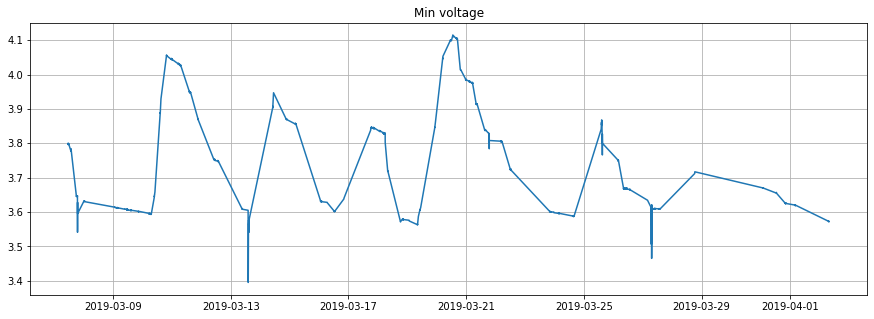

In [20]:
plt.figure(figsize=(15, 5))
plt.plot(min_v.min_voltage)
plt.title('Min voltage')
plt.grid(True)
plt.show()

### Stationarity

A stationary series is one in which the properties – mean, variance and covariance, do not vary with time. 
ADF (Augmented Dickey Fuller) Test is the test that check the stationarity of the time series.

The Dickey can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test are:

Null Hypothesis: The series has a unit root (value of a =1)

Alternate Hypothesis: The series has no unit root.

<b>If we fail to reject the null hypothesis, we can say that the series is non-stationary</b>. This means that the series can be linear or difference stationary.

In [6]:
from statsmodels.tsa.stattools import adfuller

X = min_v_cut.values
result = adfuller(min_v.min_voltage)
#print(result)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.438704
p-value: 0.131109
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


Since P-value is greater than the significance level, let’s difference the series and see how the autocorrelation plot looks like.

### Differencing 

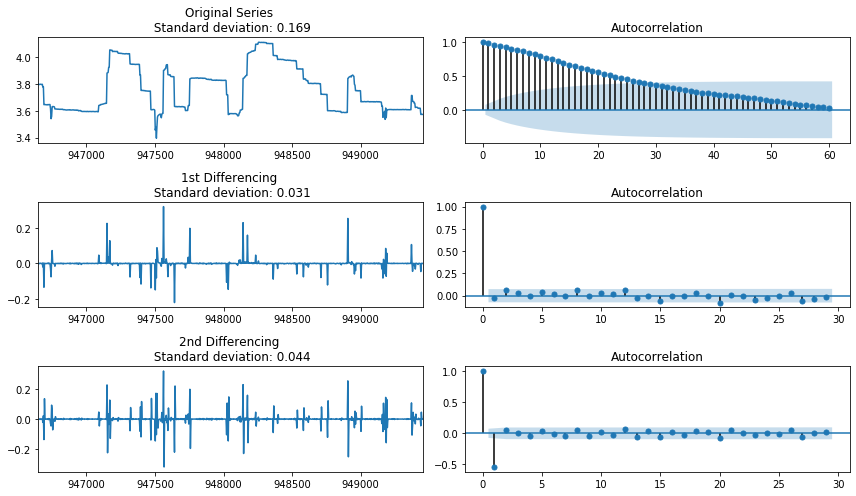

In [7]:
from statistics import stdev 
import statsmodels.api as sm

fig = plt.figure(figsize=(12,7))
layout = (3, 2)
orig_ax = plt.subplot2grid(layout, (0, 0))
acf_ax = plt.subplot2grid(layout, (0, 1))
diff_ax = plt.subplot2grid(layout, (1, 0))
diff_acf_ax = plt.subplot2grid(layout, (1, 1))
diff2_ax = plt.subplot2grid(layout, (2, 0))
diff2_acf_ax = plt.subplot2grid(layout, (2, 1))
        
min_v_cut.plot(ax=orig_ax, legend=None,) 
orig_ax.set_title('Original Series \n Standard deviation: %.3f' %(stdev(min_v_cut.min_voltage)))
sm.graphics.tsa.plot_acf(min_v_cut, lags=60, ax=acf_ax)

min_v_cut.diff().plot(ax=diff_ax, legend=None)
diff_ax.set_title('1st Differencing \n Standard deviation: %.3f' %(stdev(min_v_cut.min_voltage.diff().dropna())))
sm.graphics.tsa.plot_acf(min_v_cut.diff().dropna(), ax=diff_acf_ax)

min_v_cut.diff().diff().plot(ax=diff2_ax, legend=None)
diff2_ax.set_title('2nd Differencing \n Standard deviation: %.3f' %(stdev(min_v_cut.min_voltage.diff().diff().dropna())))
sm.graphics.tsa.plot_acf(min_v_cut.diff().diff().dropna(), ax=diff2_acf_ax)

plt.tight_layout()

As we can see, original series has positive autocorrelations out to a high number of lags.Therefore, differenicing is needed. The optimal order of differencing is often the order of differencing at which the standard deviation is lowest. The first differencing has the smallest value. 

### ARIMA modeling

First we need to define the model calling ARIMA function of the statsmodels.tsa and identify the parameters. As far as we use 1st differencing parameter d = 1. The order of the p (AR) can be inspecting via partial autocorrelation. The order of q (MA) is  technically, the error of the lagged forecast, so we can get it from the ACF

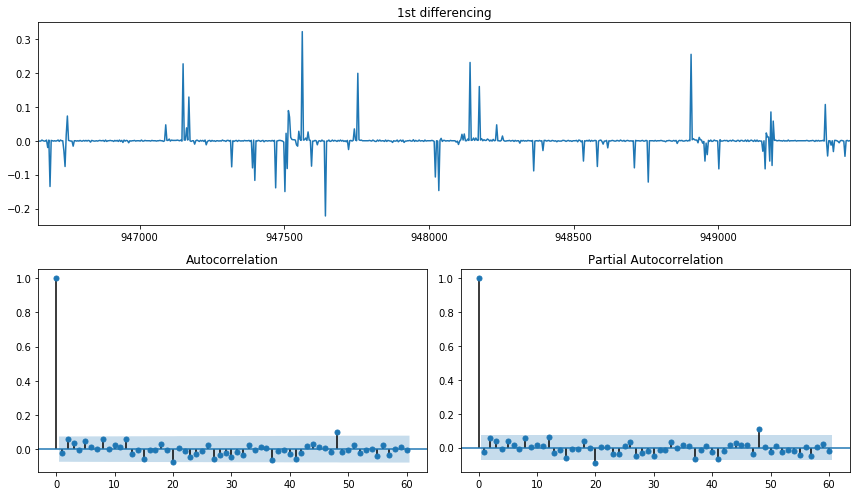

In [8]:
fig = plt.figure(figsize= (12, 7))
layout = (2, 2)
ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
acf_ax = plt.subplot2grid(layout, (1, 0))
pacf_ax = plt.subplot2grid(layout, (1, 1))
        
min_v_cut.diff().plot(ax=ts_ax, legend = None)

ts_ax.set_title('1st differencing')
sm.graphics.tsa.plot_acf(min_v_cut.diff().dropna(), lags=60, ax=acf_ax)
sm.graphics.tsa.plot_pacf(min_v_cut.diff().dropna(), lags=60, ax=pacf_ax)
plt.tight_layout()

In both ACF and PACF firs and second lags are abouve (under) the significance limit. Let's find the best combination. 

In [22]:
from itertools import product
p = range(1, 5)
d=1 
q = range(1, 5)


# creating list with all the possible combinations of parameters
parameters = product(p, q)
parameters_list = list(parameters)
parameters_list

[(1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4)]

In [10]:
from statsmodels.tsa.arima_model import ARIMA
from tqdm import tqdm_notebook

def optimizeARIMA(parameters_list, d):
    """
        Return dataframe with parameters and corresponding AIC
        parameters_list - list with (p, q) tuples
        d - integration order in ARIMA model
    """
       
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        try:
            model=ARIMA(min_v.min_voltage, order=(param[0],1,param[1])).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [24]:
result_table = optimizeARIMA(parameters_list, 1)
result_table.head()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsup

,parameters,aic
0,"(3, 2)",-15119.141946
1,"(4, 1)",-15116.913204
2,"(3, 1)",-15115.291555
3,"(1, 1)",-15114.432315
4,"(1, 2)",-15112.781669


p == 3 and q = 2 showed the best result. 

In [11]:
model = ARIMA(min_v_cut.min_voltage, order=(3,1,2)).fit()
print(model.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:          D.min_voltage   No. Observations:                  701
Model:                 ARIMA(3, 1, 2)   Log Likelihood                1443.592
Method:                       css-mle   S.D. of innovations              0.031
Date:                Tue, 12 May 2020   AIC                          -2873.183
Time:                        08:40:10   BIC                          -2841.316
Sample:                             1   HQIC                         -2860.865
                                                                              
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0003      0.001     -0.239      0.811      -0.003       0.002
ar.L1.D.min_voltage    -0.2111      0.177     -1.190      0.234      -0.559       0.137
ar.L2.D.min_volt

Now let's plot the residual to look for the constant mean and variance. 

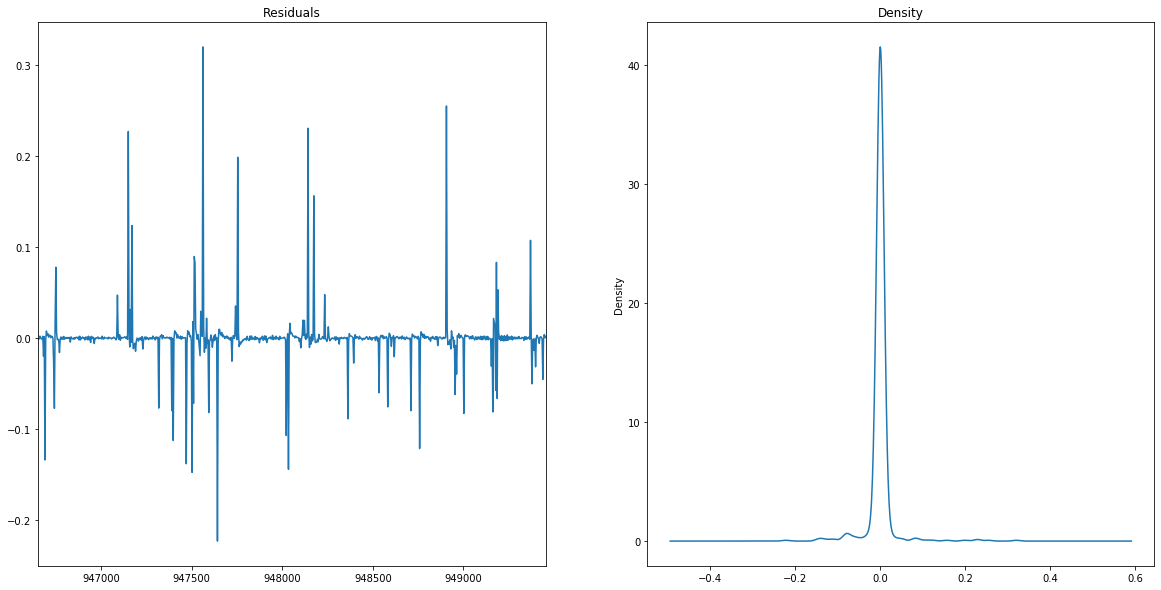

In [26]:
residuals = pd.DataFrame(model.resid)
fig, ax = plt.subplots(1,2, figsize=(20,10))
residuals.plot(title="Residuals", ax=ax[0], legend = None)
residuals.plot(kind='kde', title='Density', ax=ax[1], legend = None)
plt.show()

 Let's make predictions using our model.

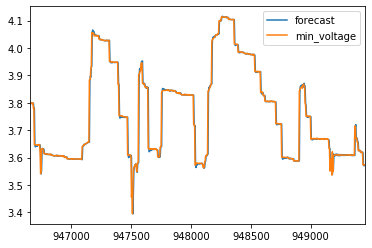

In [27]:
model.plot_predict()
plt.show()

### Forecast

Now we will train our model.

In [28]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
size = int(len(min_v_cut) * 0.90)
train, test = min_v_cut[0:size], min_v_cut[size:len(min_v_cut)]

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


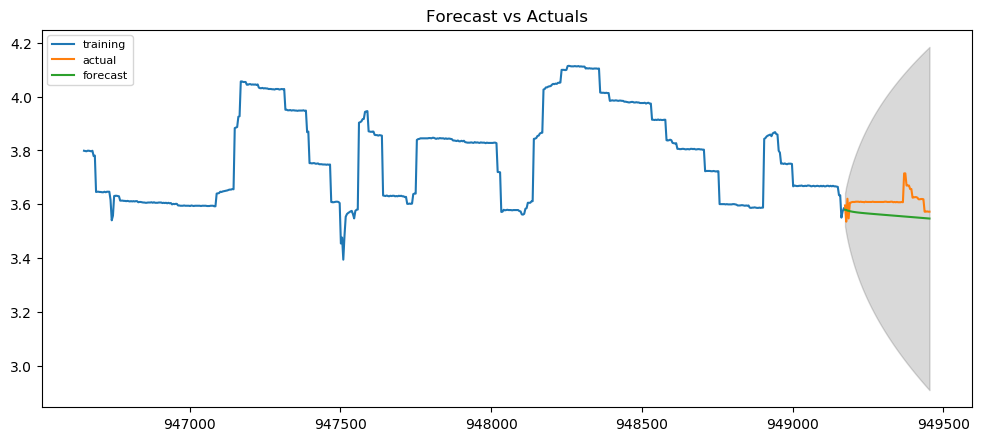

In [30]:
model = ARIMA(train, order=(3, 1, 2))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(71, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Mean squared error

In [36]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test, fc)

In [37]:
mse

0.003727823698827295